In [1]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0


In [21]:
import os
import cv2
import shutil
import numpy as np
import splitfolders
import matplotlib.pyplot as plt
import xml.etree.ElementTree as et
from glob import glob
from keras.models import Model
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import Dense, Flatten
from tensorflow.python.client import device_lib
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet121, DenseNet201, VGG19
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger

In [4]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1465451313543823471
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10063183872
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3693921690489865236
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:b3:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

label의 경우 모든 이미지 파일에 대해서 존재하고, 이미지의 경우 용량때문에 일부만 다운 받은 상태.

이미지 폴더 이름과 다른 라벨 파일들은 모두 삭제

In [17]:
image_dir = r"D:\food_dataset\dataset\images"
label_dir = r"D:\food_dataset\dataset\labels\xml"

for label_dir_name in os.listdir(label_dir):
    if label_dir_name not in os.listdir(image_dir):
        shutil.rmtree(os.path.join(label_dir, label_dir_name))

In [18]:
os.listdir(image_dir) == os.listdir(label_dir)  # 폴더 이름들이 모두 동일해짐

True

## Image crop
이미지 크롭을 위해서 label파일인 xml파일에서 bbox에 대한 정보를 가져오자.

In [101]:
image_dir = glob(r"D:\fooddataset\dataset\images\*\*")  # 이미지 디렉토리

for image_file, xml_file in zip(image_dir, label_dir):
    split_point1 = image_file.rfind('\\')  # 클래스 별 분할을 위한
    split_point2 = image_file.find("_")  # split point 생성해서
    image_foldername = image_file[split_point1+1:split_point2]  # 11, 12, 13, 14, 15, 16 폴더로 분할
    image_folder = f"./food_dataset/{image_foldername}"  # 저장될 이미지의 경로를 작성하고

    if not os.path.isdir(image_folder):  # 경로의 폴더가 없다면
        os.mkdir(image_folder)  # 생성

    image_filename = image_file[image_file.rfind("\\")+1:]  # 이미지 파일 이름 추출
    image = cv2.imread(image_file)  # 이미지를 읽어온다
    tree = et.parse(xml_file)  # label파일인 xml파일을 파싱해서
    root = tree.getroot()  # root정보를 가져온다

    points = []
    for obj in root.findall('object'):  # object안에 bbox 정보가 있기에 object를 순회하면서
        name = obj.find('name').text  # 만약 object에 달린 이름이
        if name != "dish":  # dish라는 이름이 아니라면 
            # 각 어노테이션 정보를 가져와서 리스트에 추가한 후
            xmin = int(obj.find('bndbox').find('xmin').text)
            ymin = int(obj.find('bndbox').find('ymin').text)
            xmax = int(obj.find('bndbox').find('xmax').text)
            ymax = int(obj.find('bndbox').find('ymax').text)
            points.append(xmin)
            points.append(ymin)
            points.append(xmax)
            points.append(ymax)
    cropped_image = image[points[1]:points[3], points[0]:points[2]]  # crop한 이미지를
    cv2.imwrite(os.path.join(image_folder, image_filename), cropped_image)  # 저장한다.

### 이미지 클래스 별 분포 확인

In [105]:
dataset_dir = "./food_dataset"
for class_ in os.listdir(dataset_dir):
    path = os.path.join(dataset_dir, class_)
    print(f"{path} : {len(os.listdir(path))}")

./food_dataset\11 : 7578
./food_dataset\12 : 2980
./food_dataset\13 : 2818
./food_dataset\14 : 1272
./food_dataset\15 : 3541
./food_dataset\16 : 1151


In [109]:
for class_ in os.listdir(dataset_dir):
    dir = os.path.join(dataset_dir, class_)
    for filename in os.listdir(dir)[1151:]:
        os.remove(os.path.join(dir, filename))

In [110]:
for class_ in os.listdir(dataset_dir):
    path = os.path.join(dataset_dir, class_)
    print(f"{path} : {len(os.listdir(path))}")

./food_dataset\11 : 1151
./food_dataset\12 : 1151
./food_dataset\13 : 1151
./food_dataset\14 : 1151
./food_dataset\15 : 1151
./food_dataset\16 : 1151


대분류 기준 분류 완료, 소분류 기준 분류 시작

In [124]:
test_dir = "./food_dataset/16"
ll_files = os.listdir(test_dir)

sub_cls_list = []
for filename in ll_files:
    sub = filename.replace("16_161_", "")
    sub_cls = sub[:sub.find("_")]
    sub_cls_list.append(sub_cls)

set_list = set(sub_cls_list)
for class_ in set_list:
    if not os.path.isdir(os.path.join(test_dir, class_)):
        os.mkdir(os.path.join(test_dir, class_))

In [128]:
num_list = [1, 2, 3, 5, 6]

for num in num_list:
    lst_cls = [i for i in os.listdir(f"./food_dataset/1{num}") if i.find('.') == -1]
    origin_dir = f"./food_dataset/1{num}"

    for cls in lst_cls:
        sub_dir = os.path.join(origin_dir, cls)
        work_dir = [i for i in os.listdir(origin_dir) if i.find('.') != -1]
        for filename in work_dir:
            if cls in filename:
                shutil.move(os.path.join(origin_dir, filename), os.path.join(sub_dir, filename))

In [129]:
splitfolders.ratio("./cls_dataset", "./cls_dataset2", ratio=(0.7, 0.2, 0.1), seed=11)

Copying files: 5755 files [02:43, 35.14 files/s]


In [30]:
train_generator = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    rotation_range=30,
    vertical_flip=True,
    horizontal_flip=True,
    shear_range=0.2,
    brightness_range=[0.8, 1.2]
)

valid_test_generator = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
)

train_dataset = train_generator.flow_from_directory(
    directory="./cls_dataset2/train",
    target_size=(512, 512),
    batch_size=32,
    color_mode="rgb",
    class_mode="categorical",
    seed=1337
)

valid_dataset = valid_test_generator.flow_from_directory(
    directory="./cls_dataset2/val",
    target_size=(512, 512),
    batch_size=32,
    color_mode="rgb",
    class_mode="categorical",
    seed=1337
)

test_dataset = valid_test_generator.flow_from_directory(
    directory="./cls_dataset2/test",
    target_size=(512, 512),
    color_mode="rgb",
    class_mode="categorical",
    shuffle=False
)

Found 4016 images belonging to 30 classes.
Found 1139 images belonging to 30 classes.
Found 600 images belonging to 30 classes.


In [26]:
model_path = "./food_model/models/food_model.v1.3.h5"
history_path = "./food_model/history/food_model.v1.3.csv"

In [27]:
params = {
    'input_shape' : (512, 512, 3), 
    'include_top': False,
    'weights':'imagenet',
    'classes': 30,
    "pooling" : "max"
}

base_model = DenseNet201(**params)

# 모델 커스터마이징
x = base_model.output
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(30, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 일부 레이어만 학습되도록 설정
for layer in base_model.layers:
    layer.trainable = False

els = EarlyStopping(monitor="val_loss", patience=5, mode="min")
reduce = ReduceLROnPlateau(monitor="val_loss", patience=3, mode="min", factor=0.1)
csv_logger = CSVLogger(history_path)

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
model.fit(train_dataset, epochs=100, validation_data=valid_dataset, callbacks=[els, reduce, csv_logger])
model.save(model_path)

Epoch 1/100
126/126 [==============================] - 457s 4s/step - loss: 2.9401 - accuracy: 0.1743 - val_loss: 2.1613 - val_accuracy: 0.3644 - lr: 0.0010
Epoch 2/100
126/126 [==============================] - 334s 3s/step - loss: 1.6051 - accuracy: 0.5458 - val_loss: 1.1532 - val_accuracy: 0.6752 - lr: 0.0010
Epoch 3/100
126/126 [==============================] - 333s 3s/step - loss: 1.0369 - accuracy: 0.6897 - val_loss: 1.0675 - val_accuracy: 0.6646 - lr: 0.0010
Epoch 4/100
126/126 [==============================] - 333s 3s/step - loss: 0.8523 - accuracy: 0.7331 - val_loss: 0.8441 - val_accuracy: 0.7489 - lr: 0.0010
Epoch 5/100
126/126 [==============================] - 335s 3s/step - loss: 0.7114 - accuracy: 0.7781 - val_loss: 0.7552 - val_accuracy: 0.7577 - lr: 0.0010
Epoch 6/100
126/126 [==============================] - 322s 3s/step - loss: 0.6132 - accuracy: 0.8090 - val_loss: 0.7905 - val_accuracy: 0.7515 - lr: 0.0010
Epoch 7/100
126/126 [==============================] - 319

In [31]:
model = load_model(model_path)
y_true = test_dataset.classes
y_pred = []

for pred in model.predict(test_dataset, verbose=0):
    y_pred.append(np.argmax(pred))

In [32]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.95      0.87        21
           1       0.82      0.86      0.84        21
           2       1.00      1.00      1.00        21
           3       0.92      0.57      0.71        21
           4       0.87      0.91      0.89        22
           5       0.85      0.85      0.85        13
           6       0.87      0.95      0.91        21
           7       0.83      0.75      0.79        20
           8       0.78      0.90      0.84        20
           9       0.68      0.57      0.62        23
          10       0.90      0.82      0.86        22
          11       0.76      0.87      0.81        15
          12       1.00      0.85      0.92        20
          13       1.00      0.91      0.95        22
          14       0.81      0.65      0.72        20
          15       0.64      0.90      0.75        20
          16       0.96      1.00      0.98        24
          17       0.73    

In [182]:
food_code = {
    0 : "노각무침",
    1 : "단무지 무침",
    2 : "달래나물 무침",
    3 : "더덕 무침",
    4 : "도라지 생채",
    5 : "도토리묵",
    6 : "갓김치",
    7 : "고들빼기",
    8 : "깍두기",
    9 : "깻잎김치",
    10 : "나박김치",
    11 : "동치미",
    12 : "간장게장",
    13 : "마늘쫑장아찌",
    14 : "고추장아찌",
    15 : "깻잎장아찌",
    16 : "마늘장아찌",
    17 : "무장아찌",
    18 : "가래떡",
    19 : "경단",
    20 : "꿀떡",
    21 : "시루떡",
    22 : "메밀전병",
    23 : "찰떡",
    24 : "매작과",
    25 : "다식",
    26 : "약과",
    27 : "유과",
    28 : "산과",
    29 : "깨강정"
}

Found 16 images belonging to 1 classes.


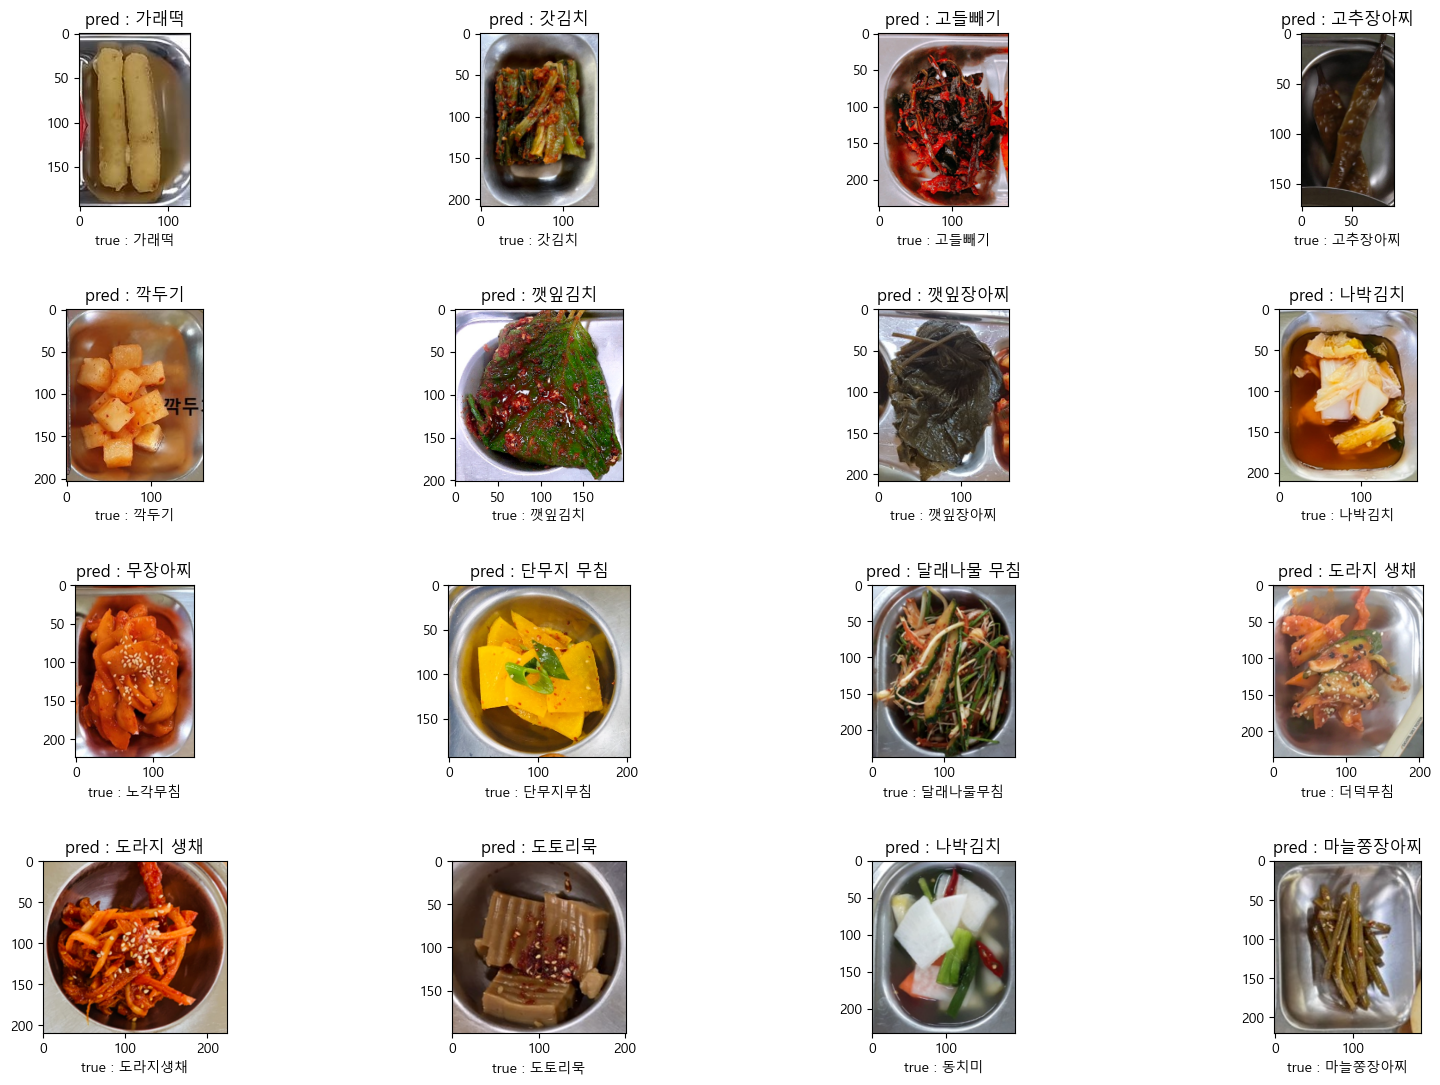

In [188]:
root_path = r"C:\Users\admin\Desktop\images"

test_case = valid_test_generator.flow_from_directory(
    root_path,
    shuffle=False,
    target_size=(256, 256),
    color_mode="rgb"
)

fig, axis = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
plt.subplots_adjust(left=0.125, bottom=0.4, right=0.9, top=0.9, wspace=0.2, hspace=0.6)

for idx, pred in enumerate(model.predict(test_case, verbose=0)):
    image_filename = test_case.filenames[idx]
    img_array = np.fromfile(os.path.join(root_path, image_filename), np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    row_col = 4

    true_class_idx = test_dataset.classes[idx]
    pred_class_idx = np.argmax(pred)
    
    true_class_name = image_filename[image_filename.find("\\")+1:image_filename.rfind(".")]
    pred_class_name = food_code[pred_class_idx]

    axis[idx//row_col][idx%row_col].imshow(image)
    axis[idx//row_col][idx%row_col].set_xlabel(f"true : {true_class_name}")
    axis[idx//row_col][idx%row_col].set_title(f"pred : {pred_class_name}")

plt.show()

### Clustering

군집화는 비지도학습의 한 예로, 어떠한 label없이 데이터 내에서 거리가 가까운 것들끼리 각 군집들로 분류하는 것이다. 

분류라고 해서 지도학습의 classification과 비슷하다고 생각할 수 있지만, 다르다

데이터 내에 숨어있는 패턴, 그룹을 파악하여 서로 묶는 것이라고 할 수 있다. 만약 라벨값이 존재하는 데이터라고 하더라도 같은 라벨 내에서도 얼마든지 다른 군집으로 묶일 가능성이 있다.

### DBSCAN Clustering


In [14]:
import cv2
import numpy as np
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt

image_path = r'C:\Users\admin\Desktop\test.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR 형식으로 이미지를 불러오므로 RGB로 변환

# # 이미지 크기 축소
# scale_percent = 20  # 원본 크기의 20%로 축소
# width = int(image.shape[1] * scale_percent / 100)
# height = int(image.shape[0] * scale_percent / 100)
# dim = (width, height)
# resized_image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)

# Step 2: 이미지 전처리
pixel_values = image.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

# Step 3: MiniBatchKMeans 알고리즘 적용
k = 10  # 원하는 클러스터 수
minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=100)
minibatch_kmeans.fit(pixel_values)

MiniBatchKMeans(batch_size=100, n_clusters=10, random_state=42)

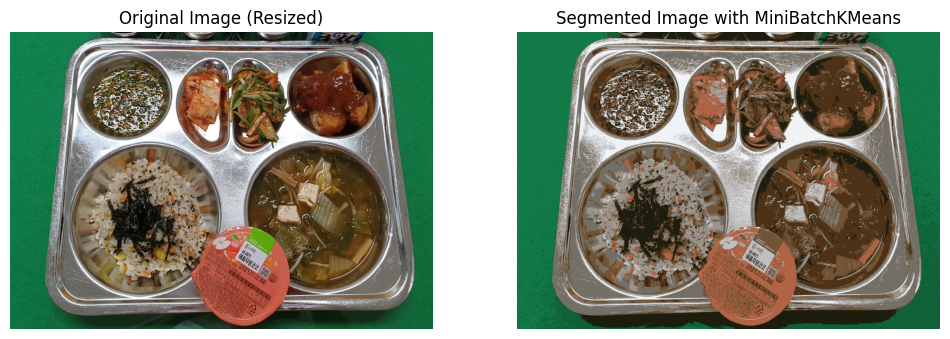

In [15]:
# 각 픽셀에 대한 클러스터 라벨 할당
labels = minibatch_kmeans.labels_
centers = minibatch_kmeans.cluster_centers_

# Step 4: 군집 결과 시각화
segmented_image = centers[labels].reshape(image.shape).astype(np.uint8)

# 원본 이미지와 군집화된 이미지 시각화
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image (Resized)")
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Segmented Image with MiniBatchKMeans")
plt.imshow(segmented_image)
plt.axis('off')

plt.show()

1/1 [==============================] - 0s 29ms/step


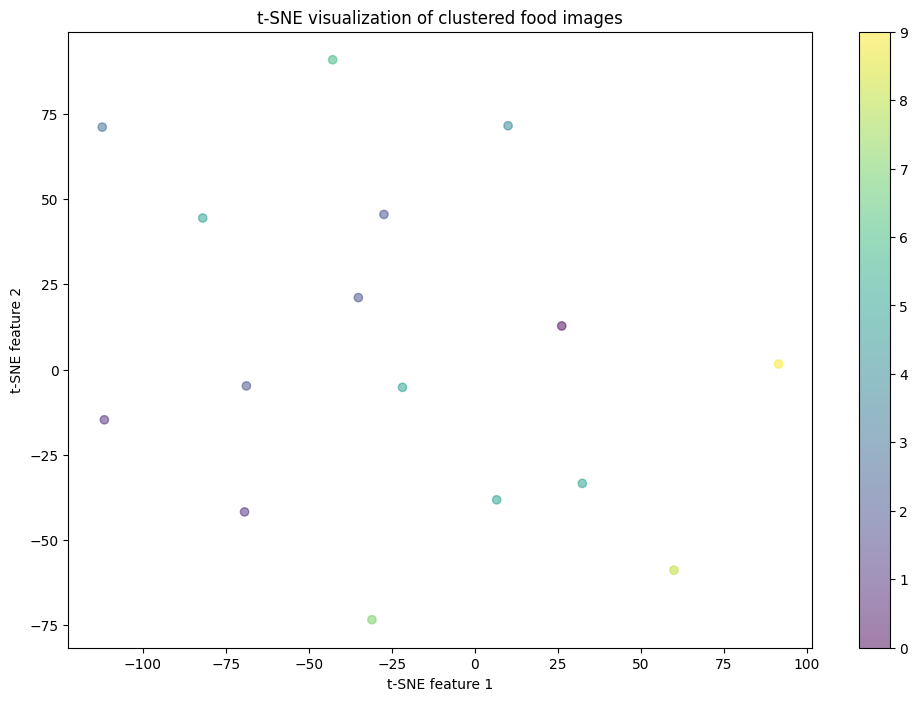

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# ResNet50 모델을 로드
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# 이미지 특징 추출 함수
def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    features = model.predict(img_data)
    return features.flatten()

# 이미지 폴더 경로
image_folder = r'C:\Users\admin\Desktop\images\food_test'

# 모든 이미지에 대해 특징 추출
features_list = []

for img_file in os.listdir(image_folder):
    img_path = os.path.join(image_folder, img_file)
    features = extract_features(img_path)
    features_list.append(features)

features_array = np.array(features_list)

# K-Means 클러스터링 수행
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(features_array)

# 각 이미지의 클러스터 할당
cluster_assignments = kmeans.labels_

# t-SNE를 사용하여 2차원으로 차원 축소
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
reduced_features = tsne.fit_transform(features_array)

# 클러스터 할당에 따라 색상 지정
plt.figure(figsize=(12, 8))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_assignments, cmap='viridis', alpha=0.5)

# 색상 바 추가
plt.colorbar(scatter, spacing='proportional')
plt.title('t-SNE visualization of clustered food images')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

In [ ]:
def classify_new_image(new_img_path):
    new_features = extract_features(new_img_path)
    new_features = new_features.reshape(1, -1)
    cluster = kmeans.predict(new_features)
    return cluster[0]

new_image_path = 'path/to/new/image.jpg'
cluster = classify_new_image(new_image_path)
print(f'The new image is classified into cluster {cluster}')